In [1]:
# Importing required libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
from torch import optim
import torch.nn.functional as F

In [2]:
# Importing the dataset
filepath = r"C:\Users\shiva\Kuzushiji-MNIST" # Folder consisting all files

train_images = np.load(os.path.join(filepath, 'kmnist-train-imgs.npz'))['arr_0']
train_labels = np.load(os.path.join(filepath, 'kmnist-train-labels.npz'))['arr_0']
test_images = np.load(os.path.join(filepath, 'kmnist-test-imgs.npz'))['arr_0']
test_labels = np.load(os.path.join(filepath, 'kmnist-test-labels.npz'))['arr_0']

print('train images shape: {}'.format(train_images.shape))
print('test images shape: {}'.format(test_images.shape))
print('train labels shape: {}'.format(train_labels.shape))
print('test labels shape: {}'.format(test_labels.shape))

train images shape: (60000, 28, 28)
test images shape: (10000, 28, 28)
train labels shape: (60000,)
test labels shape: (10000,)


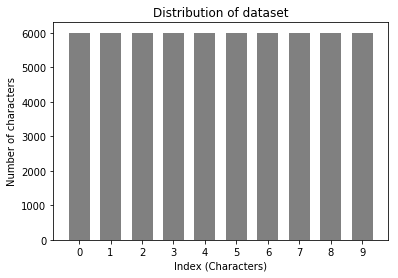

In [3]:
# Visualization of dataset
labels, counts = np.unique(train_labels, return_counts=True)
plt.bar(labels, counts, 2/3, color="grey");
plt.xticks(labels);
plt.xlabel('Index (Characters)');
plt.ylabel('Number of characters');
plt.title('Distribution of dataset');

In [4]:
# visualization of sample images from training set
random_sample = np.empty([1, 28, 28])

for i in range(len(labels)):
    sample = train_images[np.where(train_labels == i)][:1]
    sample = np.asarray(sample)
    random_sample = np.concatenate([random_sample, sample], axis=0)
    
random_sample = np.delete(random_sample, (0), axis=0)
print('random sample shape: {}'.format(random_sample.shape))

random sample shape: (10, 28, 28)


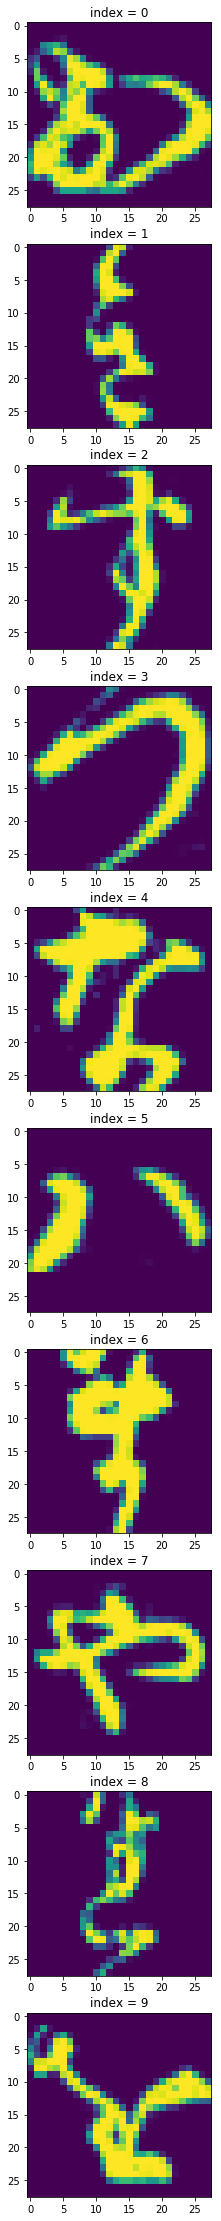

In [5]:
figure = plt.figure(figsize=(40, 40))

for i in range(len(random_sample)):
    sub = figure.add_subplot(10, 1, i+1)
    sub.imshow(random_sample[i, :, :], interpolation='nearest')
    sub.set_title('index = ' + str(i))

In [6]:
# Preprocessing the Dataset and labels
def process_images(dataset, labels):
    new_dataset = dataset.astype('float32')
    new_dataset /= 255
    new_dataset = np.reshape(new_dataset, (len(new_dataset), 1, 28, 28))
    new_labels = labels.astype('int64')
    return new_dataset, new_labels

new_train_images, new_train_labels = process_images(train_images, train_labels)

# Splitting the dataset into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(new_train_images, new_train_labels, train_size=.9, test_size=.1)

# Transforming dataset into tensors
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).type(torch.LongTensor)
X_valid = torch.Tensor(X_valid)
y_valid = torch.Tensor(y_valid).type(torch.LongTensor)

print('training dataset shape: {}'.format(X_train.shape))
print('training labels shape: {}'.format(y_train.shape))
print('validation dataset shape: {}'.format(X_valid.shape))
print('validation labels shape: {}'.format(y_valid.shape))

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = 400, shuffle = False)

valid_dataset = torch.utils.data.TensorDataset(X_valid, y_valid)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size = 400, shuffle = False)

training dataset shape: torch.Size([54000, 1, 28, 28])
training labels shape: torch.Size([54000])
validation dataset shape: torch.Size([6000, 1, 28, 28])
validation labels shape: torch.Size([6000])


In [16]:
# Building the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=0), # output dim = (400*16*24*24)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)) # output dim = (400*16*12*12)
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1), # output dim = (400*32*6*6)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.2)) # output dim = (400*32*3*3)
        self.fc1 = nn.Linear(288, 10)
        
    def forward(self, x):
        h1 = self.layer1(x)
        h2 = self.layer2(h1)
        h2 = h2.view(h2.size(0), -1)
        h3 = self.fc1(h2)
        output = F.softmax(h3, dim=1)
        return output

In [17]:
# Defining parameters
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 12
training_loss = []
valid_loss = []
training_accuracy = []
valid_accuracy = []

In [18]:
# Training the model on training and validation dataset
for epoch in range(epochs):
    model.train()
    running_loss = 0
    accuracy = 0
    steps = 0
    for i, (images, labels) in enumerate(trainloader):
        output = model(images)
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(output, 1)
        accuracy += (predicted == labels).sum()
        steps += 1
        
    training_loss.append(running_loss/steps)
    training_accuracy.append((100 * accuracy / len(train_dataset)))
        
    iter_loss = 0
    accuracy = 0
    steps = 0
    model.eval()
    for i, (images, labels) in enumerate(validloader):
        output = model(images)
        loss = criterion(output, labels)
        optimizer.zero_grad()
        iter_loss += loss.item()
        _, predicted = torch.max(output, 1)
        accuracy += (predicted == labels).sum()
        steps += 1
        
    valid_loss.append(iter_loss/steps)
    valid_accuracy.append((100 * accuracy / len(valid_dataset)))
                
    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.2f}%, Validation Loss: {:.3f}, Validation Acc: {:.2f}%'
            .format(epoch+1, epochs, training_loss[-1], training_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))

Epoch 1/12, Training Loss: 1.902, Training Accuracy: 64.00%, Validation Loss: 1.680, Validation Acc: 82.00%
Epoch 2/12, Training Loss: 1.652, Training Accuracy: 83.00%, Validation Loss: 1.624, Validation Acc: 85.00%
Epoch 3/12, Training Loss: 1.620, Training Accuracy: 85.00%, Validation Loss: 1.606, Validation Acc: 86.00%
Epoch 4/12, Training Loss: 1.602, Training Accuracy: 87.00%, Validation Loss: 1.589, Validation Acc: 88.00%
Epoch 5/12, Training Loss: 1.589, Training Accuracy: 88.00%, Validation Loss: 1.581, Validation Acc: 88.00%
Epoch 6/12, Training Loss: 1.582, Training Accuracy: 88.00%, Validation Loss: 1.576, Validation Acc: 89.00%
Epoch 7/12, Training Loss: 1.578, Training Accuracy: 89.00%, Validation Loss: 1.570, Validation Acc: 89.00%
Epoch 8/12, Training Loss: 1.575, Training Accuracy: 89.00%, Validation Loss: 1.567, Validation Acc: 89.00%
Epoch 9/12, Training Loss: 1.570, Training Accuracy: 89.00%, Validation Loss: 1.565, Validation Acc: 90.00%
Epoch 10/12, Training Loss: 

In [19]:
# Loading & Preprocessing the Test Dataset
new_test_images, new_test_labels = process_images(test_images, test_labels)

# Tranforming the test dataset into tensors
X_test = torch.Tensor(new_test_images)
y_test = torch.Tensor(new_test_labels).type(torch.LongTensor)

print('test dataset shape: {}'.format(X_test.shape))
print('test labels shape: {}'.format(y_test.shape))

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = 200)

test dataset shape: torch.Size([10000, 1, 28, 28])
test labels shape: torch.Size([10000])


In [20]:
# Importing the class to index maps
classmap = pd.read_csv(os.path.join(filepath, 'kmnist_classmap.csv'))
classmap = classmap.set_index('index')
print(classmap)

      codepoint char
index               
0        U+304A    お
1        U+304D    き
2        U+3059    す
3        U+3064    つ
4        U+306A    な
5        U+306F    は
6        U+307E    ま
7        U+3084    や
8        U+308C    れ
9        U+3092    を


In [13]:
# Saving the model
model.classmap = classmap
torch.save(model, os.path.join(filepath, 'CNN_1.pth'))

C:\Users\shiva\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [14]:
# Loading the model
torch.load(os.path.join(filepath, 'CNN_1.pth'))
model.eval()

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2)
  )
  (fc1): Linear(in_features=288, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [21]:
# Predicting results on Test Set
model.eval()
with torch.no_grad():
    accuracy = 0
    total = 0
    test_loss = 0
    for images, labels in testloader:
        output = model(images)
        loss = criterion(output, labels)
        test_loss += loss.item()
        test_loss = test_loss/len(testloader)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        accuracy += (predicted == labels).sum().item()
        test_accuracy = (100*accuracy)/total
    print('Test Loss: {:.3f}, Test Accuracy: {:.2f}%'.format(test_loss, test_accuracy))

Test Loss: 0.035, Test Accuracy: 79.53%


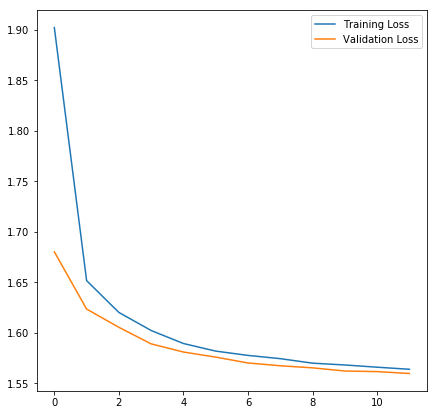

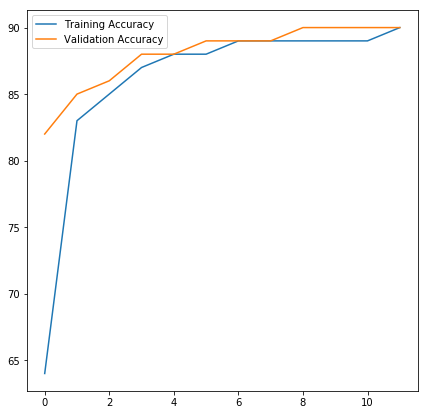

In [22]:
# Visualization of model performance on whole dataset
# Plotting Losses
f = plt.figure(figsize=(7, 7))
plt.plot(training_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.legend()
plt.show()

# Plotting Accuracies
f = plt.figure(figsize=(7, 7))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(valid_accuracy, label='Validation Accuracy')
plt.legend()
plt.show()

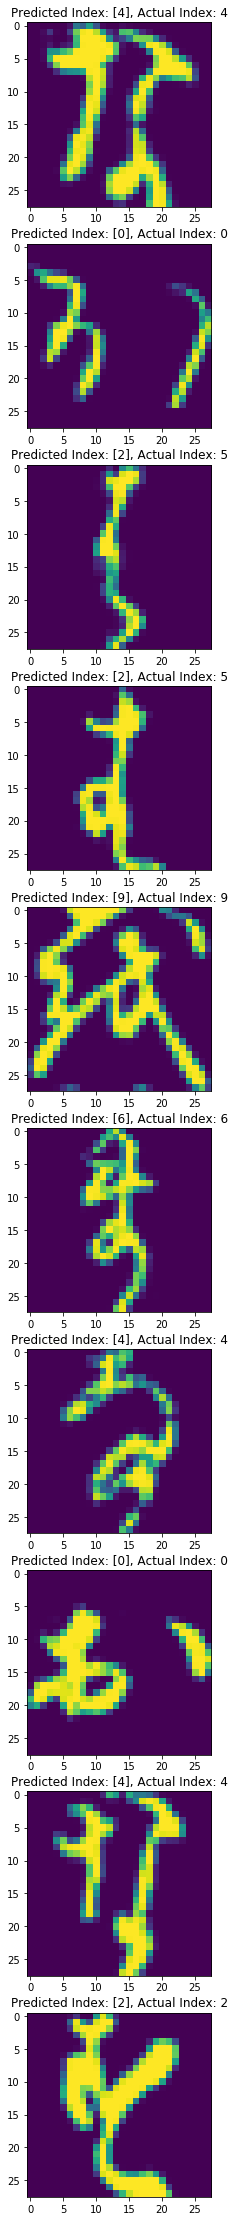

In [23]:
# Predicting on sample image dataset
sample = X_test[251: 261]
with torch.no_grad():
    output = model(sample)
    linear = torch.exp(output)

top_p, top_idx = linear.topk(1)
top_p, top_idx = top_p.numpy(), top_idx.numpy()
actual_idx = y_test[251: 261]

sample = np.asarray(sample)
sample *= 255
sample = sample.astype('float64')
sample = np.reshape(sample, [len(sample), 28, 28])
figure = plt.figure(figsize=(40, 40))
for i in range(len(sample)):
    sub = figure.add_subplot(10, 1, i+1)
    sub.imshow(sample[i, :, :], interpolation='nearest')
    sub.set_title('Predicted Index: {}, Actual Index: {}'.format(top_idx[i], actual_idx[i]))